Conda env: `aops_tenflow`

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from time import perf_counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from utils.util_write_training_result import append_training_result
from utils.util import index_of_highest_value_in_a_list
from utils.util import map_str_label, map_int_label

tf.get_logger().setLevel('ERROR')


def extract_texts_and_labels(dataset):
    texts = []
    str_labels = []
    int_labels = []
    
    for text, label in dataset:
        texts.extend(text.numpy())
        str_labels.extend([map_int_label[int(lbl)] for lbl in label.numpy()])
        int_labels.extend(label.numpy())

    return texts, str_labels, int_labels

def compare_actual_and_predict_values(model, X_list, y_actual_list_str, y_actual_list_int, predict_1by1: bool, csv_file_name_path: str):
    y_pred_list_str, y_pred_list_int = [], []
    y_pred_list_of_list_proba = []

    if predict_1by1 is True:
        for i in range(len(X_list)):
            pred_i = model.predict(tf.constant([X_list[i]]))
            y_pred_list_of_list_proba.append(pred_i)
            
            max_index_proba = int(index_of_highest_value_in_a_list(list(pred_i[0])))

            y_pred_list_str.append(map_int_label[max_index_proba])
            y_pred_list_int.append(max_index_proba)
    else:
        pred = model.predict(tf.constant(X_list))
        y_pred_list_of_list_proba = pred
        for i in range(len(y_pred_list_of_list_proba)):
            max_index_proba = int(index_of_highest_value_in_a_list(list(y_pred_list_of_list_proba[i])))

            y_pred_list_str.append(map_int_label[max_index_proba])
            y_pred_list_int.append(max_index_proba)

    df_ = pd.DataFrame({
        'text': X_list,
        'actual': y_actual_list_str,
        'predicted': y_pred_list_str,
        'actual_int': y_actual_list_int,
        'predicted_int': y_pred_list_int,
    })
    df_ = df_.sort_values(by=['actual'], ascending=True)
    df_.reset_index(inplace=True)

    display(df_.sample(10, random_state=42).sort_values(by=['actual'], ascending=True))
    df_.to_csv(csv_file_name_path, index=False)

def model_evaluate_and_analytics(model, X_list, y_actual_list_str, y_actual_list_int, predict_1by1: bool, suptitle: str, cm_file_name_path: str, figsize=(16, 10)):
    y_pred_list_str, y_pred_list_int = [], []
    y_pred_list_of_list_proba = []

    if predict_1by1 is True:
        for i in range(len(X_list)):
            pred_i = model.predict(tf.constant([X_list[i]]))
            y_pred_list_of_list_proba.append(pred_i)
            
            max_index_proba = int(index_of_highest_value_in_a_list(list(pred_i[0])))

            y_pred_list_str.append(map_int_label[max_index_proba])
            y_pred_list_int.append(max_index_proba)
    else:
        pred = model.predict(tf.constant(X_list))
        y_pred_list_of_list_proba = pred
        for i in range(len(y_pred_list_of_list_proba)):
            max_index_proba = int(index_of_highest_value_in_a_list(list(y_pred_list_of_list_proba[i])))

            y_pred_list_str.append(map_int_label[max_index_proba])
            y_pred_list_int.append(max_index_proba)

    # Calculate metrics
    loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_actual_list_int, y_pred_list_of_list_proba))
    
    metricsstr_str = classification_report(y_actual_list_str, y_pred_list_str, digits=4)
    metricsint_str = classification_report(y_actual_list_int, y_pred_list_int, digits=4)
    
    metrics_dict = classification_report(y_actual_list_str, y_pred_list_str, output_dict=True)
    metrics_dict['loss'] = loss
    
    class_names_str = ['Algebra', 'Combinatorics', 'Geometry', 'Number Theory']
    class_names_int = [0, 1, 2, 3]
    cm_str = confusion_matrix(y_actual_list_str, y_pred_list_str, labels=class_names_str)
    cm_int = confusion_matrix(y_actual_list_int, y_pred_list_int, labels=class_names_int)

    figure, ax = plt.subplots(2, 2, figsize=figsize, layout="constrained")
    figure.suptitle(suptitle)

    disp_str = ConfusionMatrixDisplay(confusion_matrix=cm_str, display_labels=class_names_str)
    disp_str.plot(ax=ax[0, 0], cmap='Greens')
    ax[0, 0].set_title('String Labels')

    disp_int = ConfusionMatrixDisplay(confusion_matrix=cm_int, display_labels=class_names_int)
    disp_int.plot(ax=ax[0, 1], cmap='Blues')
    ax[0, 1].set_title('Integer Labels')

    figure.text(0.5, 0.16, metricsstr_str, fontsize=16, ha="right", fontname="Consolas")
    figure.text(0.98, 0.16, metricsint_str, fontsize=16, ha="right", fontname="Consolas")

    figure.text(0.54, 0.12, f"loss: {loss:.4f}", fontsize=16, ha="center", fontname="Consolas")

    figure.delaxes(ax[1, 0])
    figure.delaxes(ax[1, 1])

    plt.savefig(cm_file_name_path)
    plt.show()

    return metrics_dict

id_note = "08"
batch_size = 16
epochs = 4
learning_rate = 3e-5

tfhub_map = {
    "BERTENCASEDL12H768A12" : "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-l-12-h-768-a-12/versions/4",
    # "BERT-EN-UNCASED-L-2-H-512-A-8": "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-2-h-512-a-8/2",

    "BERT-EN-CASED-PREPROCESSOR"  : "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/3",
    # "BERT-EN-UNCASED-PREPROCESSOR": "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3",
}
bert_encoder = "BERTENCASEDL12H768A12"
preprocessor = "BERT-EN-CASED-PREPROCESSOR"
bert_encoder_trainable = True


c:\Users\IBDA\.conda\envs\victor_aops_tenflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\IBDA\.conda\envs\victor_aops_tenflow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not 

## Load & prepare ds

In [2]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_ = tf.keras.utils.text_dataset_from_directory('../data/classification/train', batch_size=batch_size)
train_ds = train_ds_.cache().prefetch(buffer_size=AUTOTUNE)
train_texts, train_str_labels, train_int_labels  = extract_texts_and_labels(train_ds)

test_ds = tf.keras.utils.text_dataset_from_directory('../data/classification/test', batch_size=batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_texts, test_str_labels, test_int_labels  = extract_texts_and_labels(test_ds)

val_ds = tf.keras.utils.text_dataset_from_directory('../data/classification/val', batch_size=batch_size)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_texts, val_str_labels, val_int_labels  = extract_texts_and_labels(val_ds)

class_names = train_ds_.class_names  # ['Algebra', 'Combinatorics', 'Geometry', 'Number Theory']
print(f"\nclass: {class_names} ==> `{type(class_names)}`")


Found 2878 files belonging to 4 classes.
Found 800 files belonging to 4 classes.
Found 322 files belonging to 4 classes.

class: ['Algebra', 'Combinatorics', 'Geometry', 'Number Theory'] ==> `<class 'list'>`


## Modeling

In [3]:
class BertClassifierModel:
    def __init__(self, tfhub_preprocess, tfhub_encoder, seq_length=512):
        self.tfhub_preprocess = tfhub_preprocess
        self.tfhub_encoder = tfhub_encoder
        self.seq_length = seq_length
        self.model = self.build_model()
        self.history = None
        
        self.train_ds = None
        self.validation_data = None
        self.epochs = None
        self.learning_rate = None
        
        self.training_time = None

    def build_model(self):
        # Step 1: Define text input layer
        layer_text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='layer_text_input')
        
        # Step 2: Tokenize batches of text inputs
        bert_preprocess = hub.load(self.tfhub_preprocess)
        tokenize = hub.KerasLayer(bert_preprocess.tokenize, name='layer_tokenizer_1')
        tokenized_input = tokenize(layer_text_input)
        
        # Step 3: Pack input sequences for the Transformer encoder
        bert_pack_inputs = hub.KerasLayer(
            bert_preprocess.bert_pack_inputs,
            arguments=dict(seq_length=self.seq_length),
            name='layer_tokenizer_2'
            )
        encoder_inputs = bert_pack_inputs([tokenized_input])
        
        # Load BERT encoder
        encoder = hub.KerasLayer(self.tfhub_encoder, trainable=bert_encoder_trainable, name='BERT_encoder')
        # Pass encoder inputs through BERT encoder
        outputs = encoder(encoder_inputs)

        # Define classifier layers
        net = outputs['pooled_output']
        net = tf.keras.layers.Dropout(0.1, name='layer_dropout')(net)
        net = tf.keras.layers.Dense(4, activation='softmax', name='classifier')(net)
        
        return tf.keras.Model(inputs=layer_text_input, outputs=net, name='Classifier_model')
    
    def compile_model(self, train_ds, validation_data,epochs, learning_rate, optimizer=tf.keras.optimizers.Adam(learning_rate), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy']):
        
        self.train_ds = train_ds
        self.validation_data = validation_data
        self.epochs = epochs
        self.learning_rate = learning_rate
        
        # Comple model
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        print()
        self.model.summary(show_trainable=True)
    
    def train(self):
        print(f"Model       : {self.tfhub_encoder}")
        print(f"Preprocessor: {self.tfhub_preprocess}\n")

        print(f"epochs       : {self.epochs}")
        print(f"learning_rate: {self.learning_rate}\n")

        start = perf_counter()
        history = self.model.fit(
            self.train_ds, 
            validation_data=self.validation_data, 
            epochs=self.epochs
            )
        end = perf_counter()
        print(f"\nTotal training time: {end-start:.2f}s")
        
        self.training_time = end-start
        self.history = history.history
        return history
    
    def evaluate_test(self, test_ds):
        self.model.evaluate(test_ds)

    def plot_training_history_over_time(self, suptitle: str, plot_file_name: str, figsize=(16, 6)):
        print(self.history.keys())
        print("Training history over time")
        
        acc = self.history['accuracy']
        val_acc = self.history['val_accuracy']
        
        loss = self.history['loss']
        val_loss = self.history['val_loss']
        epochs_list = range(1, self.epochs + 1)
        
        figure, ax = plt.subplots(1, 2, figsize=figsize, layout="constrained")
        figure.suptitle(suptitle)

        plt.subplot(1, 2, 1)
        plt.plot(epochs_list, loss, 'r', label='Training loss')  # r is for "solid red line"
        plt.plot(epochs_list, val_loss, 'b', label='Validation loss')  # b is for "solid blue line"
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs_list, acc, 'r', label='Training acc')
        plt.plot(epochs_list, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')

        plt.savefig(plot_file_name)


optimizer = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.sparse_categorical_crossentropy
metrics = ['accuracy']


In [4]:
classifier_model = BertClassifierModel(tfhub_map[preprocessor], tfhub_map[bert_encoder])
classifier_model.compile_model(
    train_ds=train_ds,
    validation_data=val_ds,
    epochs=epochs, 
    learning_rate=learning_rate, 
    optimizer=optimizer, 
    loss=loss, 
    metrics=metrics)



Model: "Classifier_model"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 layer_text_input (InputLayer)  [(None,)]            0           []                               Y          
                                                                                                             
 layer_tokenizer_1 (KerasLayer)  (None, None, None)  0           ['layer_text_input[0][0]']       N          
                                                                                                             
 layer_tokenizer_2 (KerasLayer)  {'input_word_ids':   0          ['layer_tokenizer_1[0][0]']      N          
                                (None, 512),                                                                 
                                 'input_mask': (Non                                          

In [5]:
classifier_model.train()
training_time = classifier_model.training_time


Model       : https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-l-12-h-768-a-12/versions/4
Preprocessor: https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/3

epochs       : 4
learning_rate: 3e-05

Epoch 1/4
180/180 [==============================] - 75s 357ms/step - loss: 0.5458 - accuracy: 0.7943 - val_loss: 0.3874 - val_accuracy: 0.8696
Epoch 2/4
180/180 [==============================] - 64s 353ms/step - loss: 0.2906 - accuracy: 0.9058 - val_loss: 0.4153 - val_accuracy: 0.8634
Epoch 3/4
180/180 [==============================] - 64s 356ms/step - loss: 0.1809 - accuracy: 0.9437 - val_loss: 0.4387 - val_accuracy: 0.8634
Epoch 4/4
180/180 [==============================] - 64s 353ms/step - loss: 0.1253 - accuracy: 0.9580 - val_loss: 0.4825 - val_accuracy: 0.8696

Total training time: 266.62s


In [6]:
classifier_model.evaluate_test(test_ds)


50/50 [==============================] - 6s 122ms/step - loss: 0.3719 - accuracy: 0.8813


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Training history over time


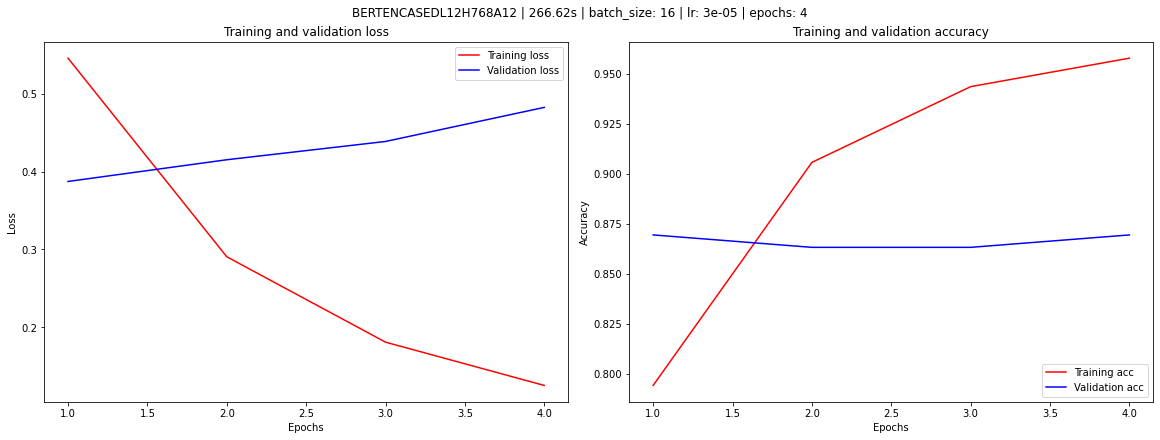

In [7]:
classifier_model.plot_training_history_over_time(
    suptitle=f"{bert_encoder} | {training_time:.2f}s | batch_size: {batch_size} | lr: {learning_rate} | epochs: {epochs}",
    plot_file_name=f"saved_plots/classification/{id_note}_{bert_encoder}_traininghistory_plot.jpg",
    figsize=(16, 6)
    )


25/25 [==============================] - 7s 265ms/step


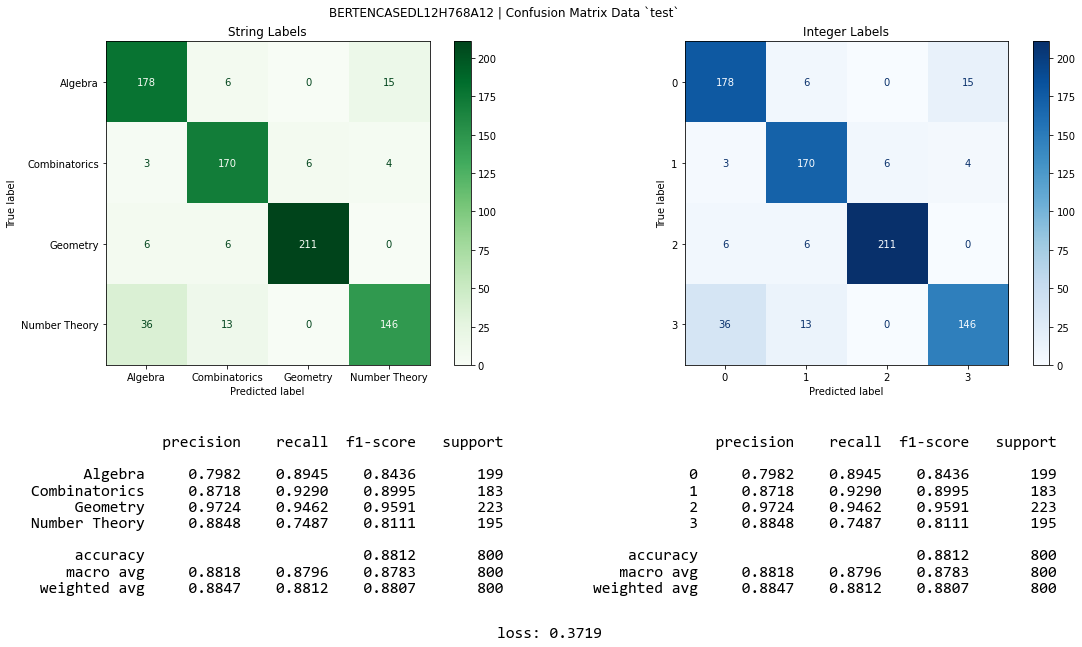

90/90 [==============================] - 24s 266ms/step


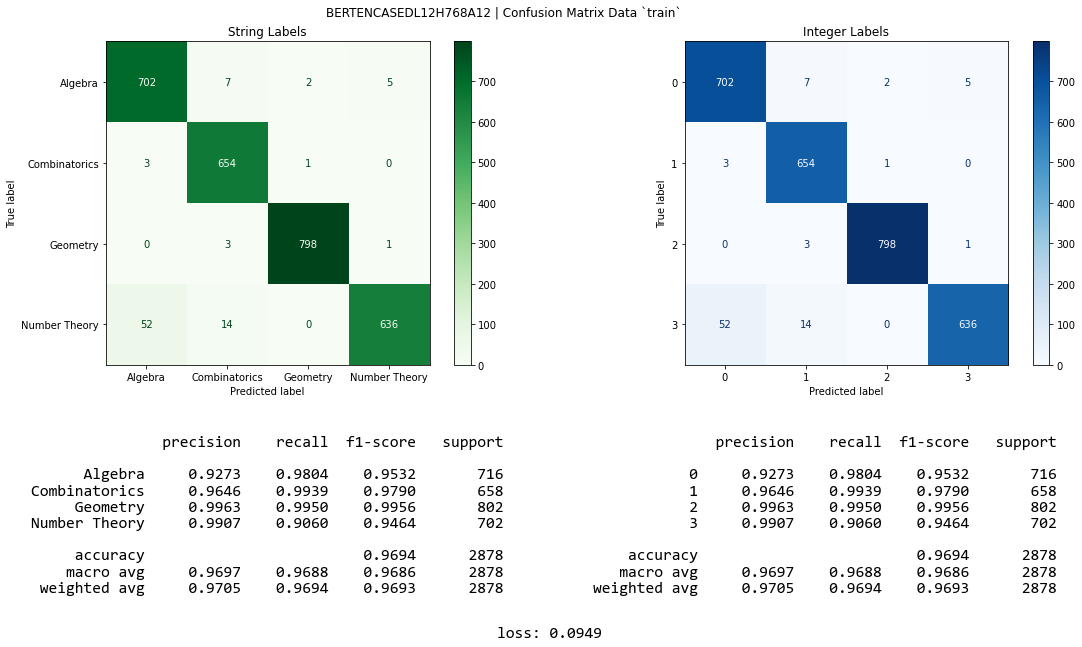

In [8]:
model_evalution_data_test = model_evaluate_and_analytics(
    classifier_model.model, 
    test_texts,
    test_str_labels,
    test_int_labels,
    predict_1by1=False,
    suptitle=f"{bert_encoder} | Confusion Matrix Data `test`",
    cm_file_name_path=f"saved_plots/classification/{id_note}_{bert_encoder}_cmplot_test.jpg",
    figsize=(16, 10),
    )

model_evalution_data_train = model_evaluate_and_analytics(
    classifier_model.model, 
    train_texts,
    train_str_labels,
    train_int_labels,
    predict_1by1=False,
    suptitle=f"{bert_encoder} | Confusion Matrix Data `train`",
    cm_file_name_path=f"saved_plots/classification/{id_note}_{bert_encoder}_cmplot_train.jpg",
    figsize=(16, 10),
    )


In [9]:
compare_actual_and_predict_values(
    model=classifier_model.model,
    X_list=test_texts,
    y_actual_list_str=test_str_labels,
    y_actual_list_int=test_int_labels,
    predict_1by1=False,
    csv_file_name_path=f"saved_plots/classification/{id_note}_{bert_encoder}_test.csv",
    )

compare_actual_and_predict_values(
    model=classifier_model.model,
    X_list=train_texts,
    y_actual_list_str=train_str_labels,
    y_actual_list_int=train_int_labels,
    predict_1by1=False,
    csv_file_name_path=f"saved_plots/classification/{id_note}_{bert_encoder}_train.csv",
    )


25/25 [==============================] - 7s 267ms/step


,index,text,actual,predicted,actual_int,predicted_int
63,191,b'Determine all the functions f : mathbb{R} to...,Algebra,Algebra,0,0
66,185,b'Find all functions f: mathbb{R} to mathbb{R}...,Algebra,Algebra,0,0
346,715,"b'Let p,q,n be three positive integers with p ...",Combinatorics,Combinatorics,1,1
533,49,b'Let PQRS be a cyclic quadrilateral such that...,Geometry,Geometry,2,2
490,178,"b'Consider a circle with centre O, and 3 point...",Geometry,Geometry,2,2
456,722,b'Let ABC be a triangle with circumcircle omeg...,Geometry,Geometry,2,2
696,44,"b'Prove that for any positive integers x, y, z...",Number Theory,Number Theory,3,3
667,15,b'Find all functions f: mathbb Z_{>0} to mathb...,Number Theory,Number Theory,3,3
621,77,b'For each positive integer m let t_m be the s...,Number Theory,Number Theory,3,3
760,412,"b'Let a_1,a_2 , ldots, a_n be an arithmetic pr...",Number Theory,Number Theory,3,3


90/90 [==============================] - 23s 263ms/step


,index,text,actual,predicted,actual_int,predicted_int
471,64,"b'Let n be an odd positive integer, and let x_...",Algebra,Algebra,0,0
1094,62,"b'A set S= { s_1,s_2,...,s_k } of positive rea...",Combinatorics,Combinatorics,1,1
1255,717,b'A collection of n squares on the plane is ca...,Combinatorics,Combinatorics,1,1
1128,2308,b'The underline{ text{path number}} of a graph...,Combinatorics,Combinatorics,1,1
945,1691,b'The diagonals of a convex 18-gon are colored...,Combinatorics,Combinatorics,1,1
1453,2418,b'Let the circles k_1 and k_2 intersect at two...,Geometry,Geometry,2,2
1601,2112,b'Let P be a polygon that is convex and symmet...,Geometry,Geometry,2,2
1800,200,"b'Let a,b,c be the lengths of the sides of a t...",Geometry,Geometry,2,2
2376,707,b'Determine all the sets of six consecutive po...,Number Theory,Number Theory,3,3
2251,2760,b'Show that there exists a bijective function ...,Number Theory,Number Theory,3,3


In [10]:
temp = f"{id_note},classification,{bert_encoder},{preprocessor},{batch_size},{epochs},{learning_rate},tf.keras.optimizers.Adam,"
temp+= f"{bert_encoder_trainable},{training_time:.2f},{model_evalution_data_test['loss']:.7f},"
temp+= f"{model_evalution_data_test['accuracy']:.7f},{model_evalution_data_test['macro avg']['precision']:.7f},"
temp+= f"{model_evalution_data_test['macro avg']['recall']:.7f},{model_evalution_data_test['macro avg']['f1-score']:.7f}"

append_training_result("Hasil training - Classification.csv", temp)


In [11]:
# # Save model
# svdmodel_path = f"saved_models/classification/{id_note}_{bert_encoder}"
# classifier_model.model.save(svdmodel_path, include_optimizer=False)

# # Try load after save
# loaded_model = tf.saved_model.load(svdmodel_path)
# print(loaded_model(tf.constant(["Given triangle $ABCD$"])))


In [12]:
raise KeyError("Error")

KeyError: 'Error'

In [ ]:
# from sklearn.metrics import log_loss
# from tensorflow.keras.losses import sparse_categorical_crossentropy
# from tensorflow import constant
# from tensorflow import reduce_mean


# y_true = constant([0, 1, 2, 0, 1])

# y_pred_proba = constant([
#     [0.7, 0.2, 0.1],
#     [0.1, 0.6, 0.3],
#     [0.2, 0.3, 0.5],
#     [0.8, 0.1, 0.1],
#     [0.3, 0.5, 0.2]
# ])

# loss1 = log_loss(y_true, y_pred_proba)
# loss2 = reduce_mean(sparse_categorical_crossentropy(y_true, y_pred_proba)).numpy()


# print("Log Loss1:", loss1)
# print("Log Loss2:", loss2)
